In [40]:
import numpy as np
import os
import glob
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow import keras

import pathlib
import cv2 as cv

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn

In [2]:
print(tf.__version__)

2.5.0


<h1> Loading the images </h1>
<h2> Loading the training images </h2>
<h4> (Need better testing and training images) </h4>

Image loading section from https://www.tensorflow.org/tutorials/load_data/images

In [7]:
# Set a Path object pointing to the path of the training folder.
train_dir = pathlib.Path("ASL_Gestures/Train")

# Checking if all 87,000 images are loaded in the training set.
image_count = len(list(train_dir.glob('*/*.jpg')))
print(image_count)

87000


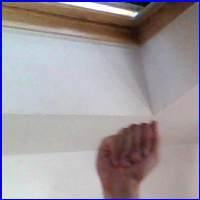

In [8]:
A = list(train_dir.glob('A/*'))
PIL.Image.open(str(A[0]))

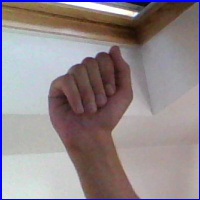

In [9]:
A = list(train_dir.glob('A/*'))
PIL.Image.open(str(A[1]))

<h2> Loading the Testing Images </h2>

In [10]:
# Set a Path object pointing to the path of the training folder.
test_dir = pathlib.Path("ASL_Gestures/Test/")

# Checking if all 28 images are loaded in the training set.
image_count = len(list(test_dir.glob('*/*.jpg')))
print(image_count)

28


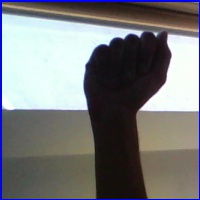

In [11]:
A = list(test_dir.glob('A/*.jpg'))
PIL.Image.open(str(A[0]))

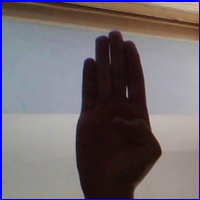

In [12]:
B = list(test_dir.glob('B/*.jpg'))
PIL.Image.open(str(B[0]))

In [13]:
X_test = []
y_test = []
files = glob.glob("ASL_Gestures/Test/*.jpg")
for file in files:
    image = cv.imread(file)
    baseName = os.path.basename(file)
    y_test.append(os.path.splitext(baseName)[0])
    X_test.append(image)

print('X_test shape:', np.array(X_test).shape)
print('Y_test:', y_test)

X_test shape: (0,)
Y_test: []


<h3> Creating datasets </h3>

Parameters

In [14]:
batch_size = 32
img_height = 200
img_width = 200

In [50]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.3,
    subset="training",
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 87000 files belonging to 29 classes.
Using 60900 files for training.


In [51]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.3,
    subset="validation",
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 87000 files belonging to 29 classes.
Using 26100 files for validation.


In [53]:
class_names = train_dataset.class_names
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [52]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
)

Found 28 files belonging to 29 classes.


<h3> Visualize the data before moving on to modeling </h3>

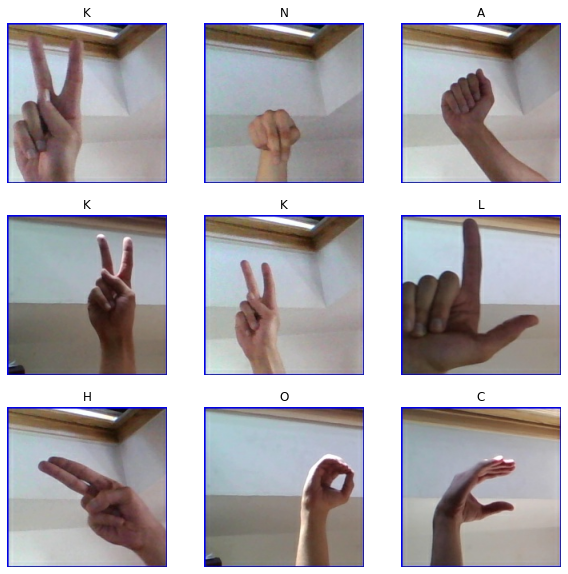

In [58]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[tf.argmax(labels[i], axis=0)])
        plt.axis("off")


In [59]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 200, 200, 3)
(32, 29)


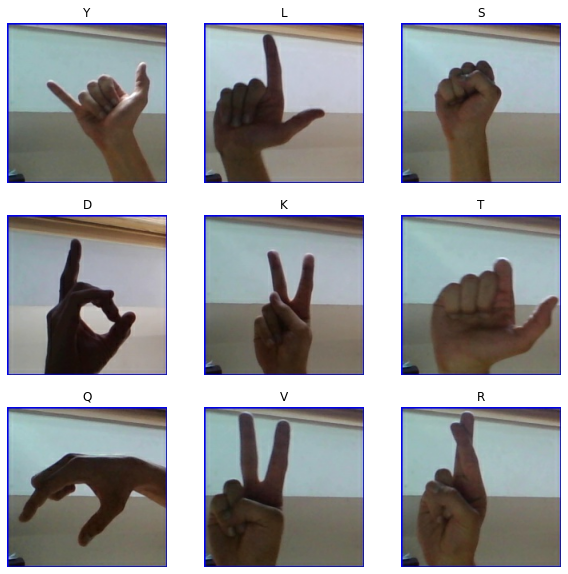

In [84]:
## Test Data Visualizations
plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[tf.argmax(labels[i], axis=0)])
        plt.axis("off")

<h3> One-Hot Encode Data </h3>

In [41]:
# Get y labels for training
y_train = np.concatenate([y for x, y in train_dataset], axis=0)

# One-hot encode
y_train = tf.keras.utils.to_categorical(y_train, len(class_names))

In [44]:
# Get y labels for testing
y_test = np.concatenate([y for x,y in test_dataset], axis=0)

# One-hot encode
y_test = tf.keras.utils.to_categorical(y_test, len(class_names))

Rescale data

In [60]:
normalize_l = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

<h2> Training the Model </h2>

<h3>Transfer learning from a pre-trained model</h3>

In [76]:
# Training checkpoints 
class accuracyCheck95(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy')>=0.95 and epoch >= 2):
            self.model.stop_training = True

callbacks_95 = accuracyCheck95()

<h3> Ignore for now </h3>

In [16]:
transfer = keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(200,200,3), pooling='max', input_tensor=None)

In [18]:
net = transfer.output

In [19]:
# Adding top layers
net = layers.Flatten()(net)
net = layers.Activation('relu')(net)
net = layers.Dense(128)(net)
net = layers.Dropout(rate=0.5)(net)
output = layers.Dense(29)(net)

In [20]:
# Building the model
transfer_model = keras.Model(inputs=transfer.input, outputs=output)

In [21]:
# Make the transfer layers non-trainable (to make training quicker)
for layer in transfer.layers: layer.trainable = False

In [22]:
# Compiling the model

transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
# Train the model
history_transfer = transfer_model.fit(train_dataset, validation_data=validation_dataset, epochs=20, callbacks=[callbacks_65])

<h3> Till Here, Ignore </h3>

In [77]:
num_classes = 29

model = tf.keras.models.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu', input_shape=(200, 200, 3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(num_classes, activation='softmax')
])


In [78]:
model.compile(
  optimizer='adam',
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [79]:
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=5,
  callbacks=[callbacks_95]
)

Epoch 1/5
1904/1904 [==============================] - 697s 366ms/step - loss: 0.7521 - accuracy: 0.7880 - val_loss: 0.9448 - val_accuracy: 0.7075
Epoch 2/5
1904/1904 [==============================] - 713s 374ms/step - loss: 0.1066 - accuracy: 0.9697 - val_loss: 0.2967 - val_accuracy: 0.9001
Epoch 3/5
1904/1904 [==============================] - 752s 395ms/step - loss: 0.0573 - accuracy: 0.9834 - val_loss: 0.1687 - val_accuracy: 0.9445
Epoch 4/5
1904/1904 [==============================] - 704s 370ms/step - loss: 0.0425 - accuracy: 0.9868 - val_loss: 0.1605 - val_accuracy: 0.9484
Epoch 5/5
1904/1904 [==============================] - 695s 365ms/step - loss: 0.0349 - accuracy: 0.9885 - val_loss: 0.1439 - val_accuracy: 0.9543


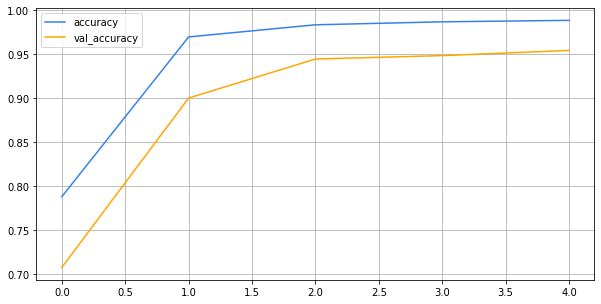

In [80]:

plt.figure(figsize=(10,5))

accuracy_label = 'accuracy'

acc_metric = history.history[accuracy_label]
val_acc_metric = history.history['val_'+accuracy_label]

num_epoch = range(0, len(acc_metric))

plt.plot(num_epoch, acc_metric, color='#3480eb')
plt.plot(num_epoch, val_acc_metric, color='orange')

plt.legend([accuracy_label, 'val_'+accuracy_label])

plt.grid()
plt.show()

<h4> Save Model </h4>

In [81]:
!mkdir -p asl_model_saved
model.save('asl_model_saved/asl_Model.h5')

Evaluate Model (Need to change to code from markup)

In [82]:
test_loss, test_acc = model.evaluate(test_dataset)

1/1 [==============================] - 0s 83ms/step - loss: 0.2385 - accuracy: 0.9643


In [83]:
predictions = model.predict(test_dataset)
classes = np.argmax(predictions, axis=1)
for i in classes:
    print(class_names[i])


Q
N
B
J
U
L
E
A
O
Z
H
Y
S
F
X
M
T
V
P
I
W
K
C
space
U
D
G
nothing


<h2> Load Saved Pre-Trained Model </h2>

In [85]:
loaded_model = tf.keras.models.load_model('asl_model_saved/asl_Model.h5')

In [86]:
loaded_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_7 (Rescaling)      (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 97, 97, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)              

<h3> Test with OpenCV and camera </h3>

In [87]:
# Predict gesture
def predict_asl(img):
    img = img.reshape(1, 200, 200, 3)
    return class_names[np.argmax(loaded_model.predict(img))]

In [91]:
cap = cv.VideoCapture(0)
if not cap.isOpened():
    print("Error : Camera cannot be opened")
    exit()
while True:
    #Capture frame-by-frame
    ret, frame = cap.read()
    
    # if frame is read correctly, ret is True
    if not ret:
        print ("Frame Error : Cannot receive frame.")
        break
    
    frame = cv.resize(frame, (200, 200), 3)
    label = predict_asl(frame)
    frame = cv.putText(frame, label, (50,50), cv.FONT_HERSHEY_COMPLEX, 1, (255,0,255), 1)
    cv.imshow('frame', frame)
    if cv.waitKey(1) == ord('e'):
        break

# Release capture if exiting
cap.release()
cv.destroyAllWindows()

Frame Error : Cannot receive frame.
